# Papers:
- [Deep Fake Detector](http://cs230.stanford.edu/projects_winter_2019/reports/15812450.pdf)

In [8]:
import os
import cv2
import math
import torch
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [17]:
CLASSES_IDS = {
    'REAL': 0,
    'FAKE': 1
}

CLASSES_NAMES = {
    0: 'real',
    1: 'fake'
}

class DeepFakeDataset(Dataset):
    """Fake vs Real."""

    def __init__(self, root_dir, split='train', transform=None):
        assert split in ['train', 'test']
        
        self.__root_dir = root_dir
        self.__split = split
        self.__transform = transform

        self.__split_dir = os.path.join(root_dir, split)
        classes = os.listdir(self.__split_dir)

        self.__image_labels = []
        self.__images = []

        for cls in classes:
            for image in os.listdir(os.path.join(self.__split_dir, cls)):
                self.__image_labels.append(cls)
                self.__images.append(image)

        assert len(self.__images) == len(self.__image_labels)

    def __len__(self):
        return len(self.__images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_label = self.__image_labels[idx]
        image_name = os.path.join(self.__root_dir,
                                  self.__split,
                                  image_label,
                                  self.__images[idx])
        
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.__transform:
            image = self.__transform(image)

        return image, CLASSES_IDS[image_label]

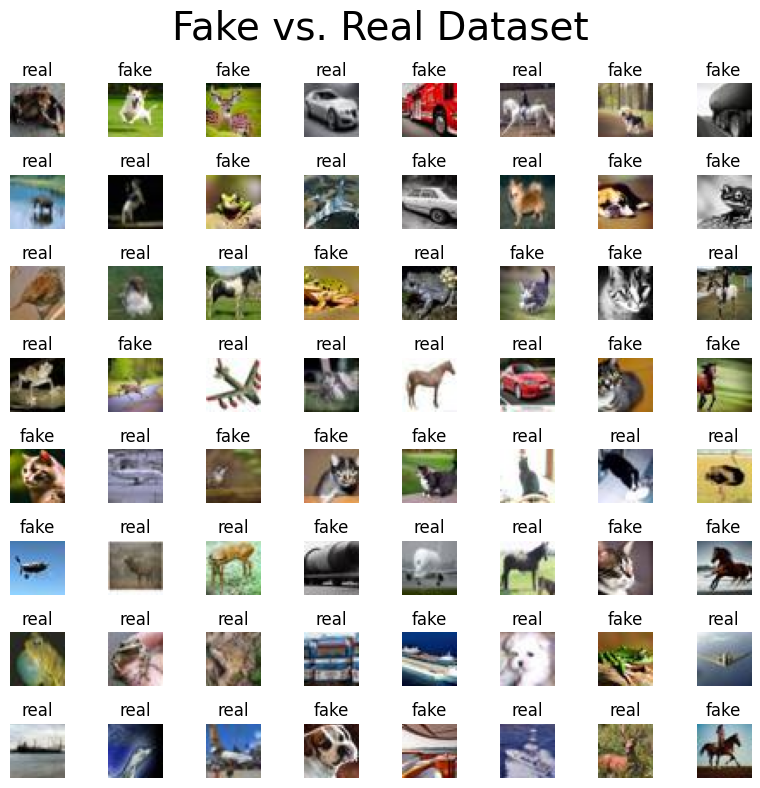

In [18]:
def load_reshape_img(path, shape=(224,224,3)):
    img = load_img(path, target_size=shape)
    x = img_to_array(img) / 255.0
    x = x.reshape((1, ) + x.shape)
    return x

dataset = DeepFakeDataset('./temp/dataset')
indices = np.random.randint(0, len(dataset), 64)

def layout(dataset, indices, row_size = 8):
    fig, ax = plt.subplots(nrows=math.ceil(len(indices) / row_size), ncols=row_size, figsize=(8, 8))
    fig.suptitle('Fake vs. Real Dataset', fontsize=28)
    
    for i, index in enumerate(indices):
        image, label = dataset[index]

        grid_i = i // row_size
        grid_j = i % row_size

        ax[grid_i, grid_j].axis("off")
        ax[grid_i, grid_j].set_title(CLASSES_NAMES[label])
        ax[grid_i, grid_j].imshow(image)

layout(dataset, indices)
plt.tight_layout()
plt.show()